## EDA for Census Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from plotnine.data import *

In [2]:
census = pd.read_csv('data/census_starter.csv')
train = pd.read_csv('data/train.csv')

In [3]:
census.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

In [4]:
id_vars = ['cfips']

# melt the dataframe and add a new column 'year'
census_long = pd.melt(census, id_vars=id_vars, var_name='variable', value_name='value')
census_long['year'] = census_long['variable'].apply(lambda x: int(x.split('_')[-1]))

# extract the variable name without the year using regular expressions
census_long['variable'] = census_long['variable'].str.extract(r'(\w+)_\d+')

# pivot the dataframe wider using the variable names
census_wide = census_long.pivot(index=['cfips', 'year'], columns='variable', values='value').reset_index()

# census_wide.drop(columns=['variable'], axis = 1)



In [5]:
census_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15710 entries, 0 to 15709
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cfips             15710 non-null  int64  
 1   year              15710 non-null  int64  
 2   median_hh_inc     15705 non-null  float64
 3   pct_bb            15708 non-null  float64
 4   pct_college       15708 non-null  float64
 5   pct_foreign_born  15708 non-null  float64
 6   pct_it_workers    15707 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 859.3 KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


#### We prob won't see YoY pattern differences, so we can pick several cfips and look at the time series by year. then we need to average out microbusiness density for year.

In [7]:
state_cfip = train[['cfips', 'county', 'state']].drop_duplicates().reset_index(drop=True)

state_cfip.head()

,cfips,county,state
0,1001,Autauga County,Alabama
1,1003,Baldwin County,Alabama
2,1005,Barbour County,Alabama
3,1007,Bibb County,Alabama
4,1009,Blount County,Alabama


In [8]:
train['year'] = train['first_day_of_month'].apply(lambda x: int(x.split('-')[0]))
train.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019


In [9]:
train[train.cfips == 1001].head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019


In [10]:
train_drop = train.drop(columns=['row_id', 'county', 'state'], axis = 1)
train_grouped = train_drop.groupby(['cfips', 'year'], squeeze = True).mean()

/var/folders/wr/8dtktkf96kbf1b8fg55tb8x80000gn/T/ipykernel_86134/875879975.py:2: FutureWarning: The `squeeze` parameter is deprecated and will be removed in a future version.


In [11]:
train_grouped.reset_index(inplace=True)

In [12]:
train_grouped.head()

,cfips,year,microbusiness_density,active
0,1001,2019,2.986972,1240.400000
1,1001,2020,3.044592,1273.583333
2,1001,2021,3.181585,1341.833333
3,1001,2022,3.376788,1435.000000
4,1003,2019,7.370375,11671.800000


#### Here we made three separate datasets out of train.csv and census_starter.csv:

##### 1. **train_grouped**: grouped by cfips and year, with the average of microbusiness density and activity for that year
##### 2. **state_cfips**: a county and state identified by cfips
##### 3. **census_wide**: melted the census data columns into one column, then pivot wider, separated by year.

In [13]:
df = pd.merge(train_grouped, census_wide, on=['cfips', 'year'], how='inner')

In [14]:
df.head()

,cfips,year,microbusiness_density,active,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers
0,1001,2019,2.986972,1240.400000,58731.0,80.6,16.1,2.3,0.7
1,1001,2020,3.044592,1273.583333,57982.0,82.7,16.7,2.3,0.6
2,1001,2021,3.181585,1341.833333,62660.0,85.5,16.4,2.1,1.1
3,1003,2019,7.370375,11671.800000,58320.0,81.8,21.0,3.7,1.4
4,1003,2020,7.812648,12690.083333,61756.0,85.1,20.2,3.4,1.0


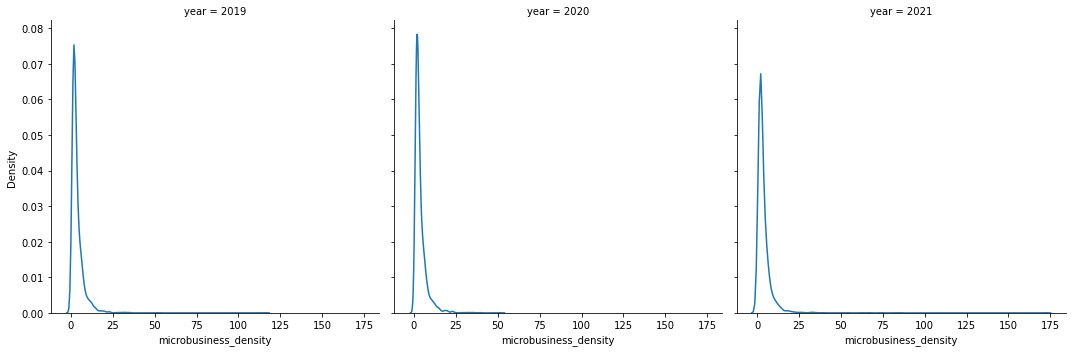

In [15]:
sns.displot(data=df, kind='kde', x='microbusiness_density', col='year')

/Users/sding/opt/anaconda3/envs/msca/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 31 rows containing missing values.


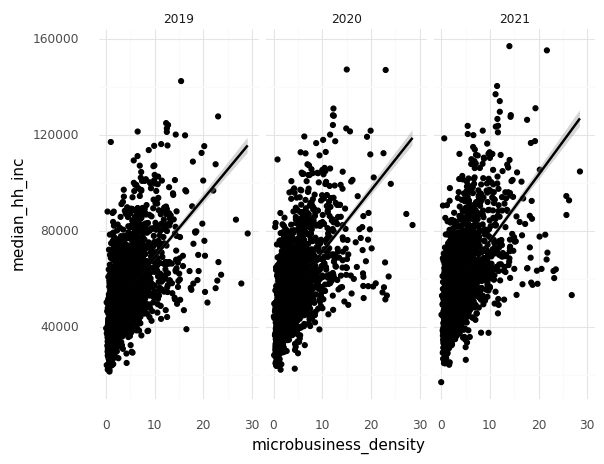

<ggplot: (8761412387988)>

In [23]:
(ggplot(df, aes(x='microbusiness_density', y='median_hh_inc')) + 
       geom_point() +
       geom_smooth() +
         facet_wrap('year') +
         theme_minimal() +
         xlim(0, 30)) 

/Users/sding/opt/anaconda3/envs/msca/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 29 rows containing missing values.


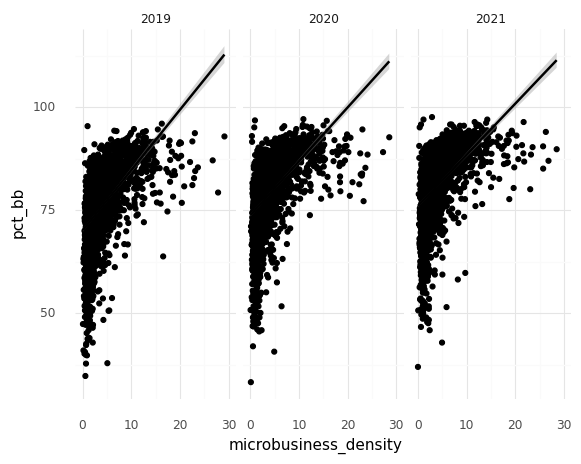

<ggplot: (8761390507984)>

In [16]:
(ggplot(df, aes(x='microbusiness_density', y='pct_bb')) + 
       geom_point() +
       geom_smooth() +
         facet_wrap('year') +
         theme_minimal() +
         xlim(0, 30)) 

/Users/sding/opt/anaconda3/envs/msca/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 29 rows containing missing values.


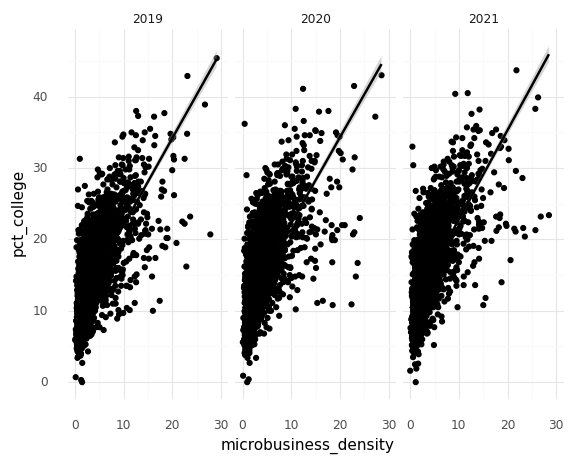

<ggplot: (8761373400495)>

In [17]:
(ggplot(df, aes(x='microbusiness_density', y='pct_college')) + 
       geom_point() +
       geom_smooth() +
         facet_wrap('year') +
         theme_minimal() +
         xlim(0, 30)) 

/Users/sding/opt/anaconda3/envs/msca/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 32 rows containing missing values.


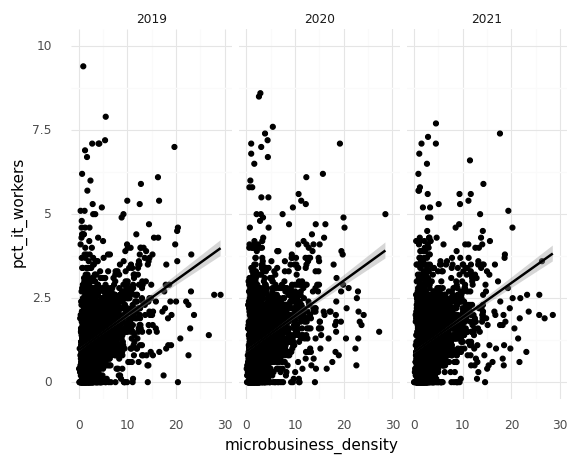

<ggplot: (8761412034702)>

In [18]:
(ggplot(df, aes(x='microbusiness_density', y='pct_it_workers')) + 
       geom_point() +
       geom_smooth() +
         facet_wrap('year') +
         theme_minimal() +
         xlim(0, 30) + 
         ylim((0,10))) 

/Users/sding/opt/anaconda3/envs/msca/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 29 rows containing missing values.


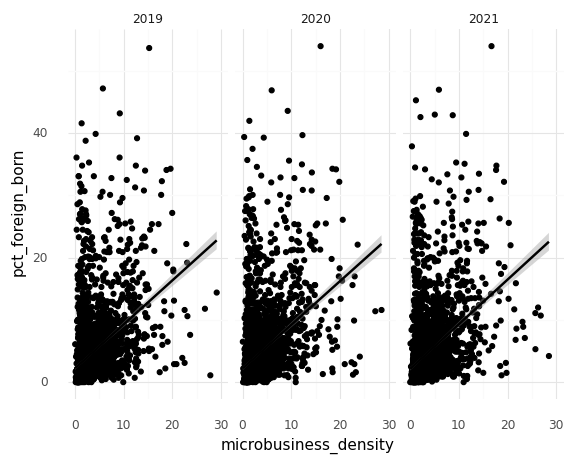

<ggplot: (8761412031841)>

In [19]:
(ggplot(df, aes(x='microbusiness_density', y='pct_foreign_born')) + 
       geom_point() +
       geom_smooth() +
         facet_wrap('year') +
         theme_minimal() +
         xlim(0, 30)) 

In [22]:
# corr plot
df[['microbusiness_density','median_hh_inc', 'pct_bb', 'pct_college', 'pct_it_workers', 'pct_foreign_born']].corr().style.background_gradient(cmap='coolwarm')

,microbusiness_density,median_hh_inc,pct_bb,pct_college,pct_it_workers,pct_foreign_born
microbusiness_density,1.000000,0.438612,0.393504,0.539968,0.276133,0.312437
median_hh_inc,0.438612,1.000000,0.714444,0.710571,0.306177,0.386903
pct_bb,0.393504,0.714444,1.000000,0.638130,0.274360,0.287311
pct_college,0.539968,0.710571,0.638130,1.000000,0.358348,0.332038
pct_it_workers,0.276133,0.306177,0.274360,0.358348,1.000000,0.203834
pct_foreign_born,0.312437,0.386903,0.287311,0.332038,0.203834,1.000000
